In [193]:
import os
import json
import pandas as pd
import numpy as np
from time import time


from aix360.algorithms.rbm import FeatureBinarizer
from aix360.algorithms.rbm import BRCGExplainer, BooleanRuleCG, GLRMExplainer, LogisticRuleRegression


from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.image as mpl_image
import matplotlib.pyplot as plt

%matplotlib inline 
sns.set(style="white")

In [194]:
start_time = time()
with open("../configuration.json", 'rt') as infile:
    config = json.load(infile)


sources = [os.path.join("..", config['paths']['output'], 
                        d['name'], 
                        'data.csv') for d in config['sources'] if d['name']]


# Generate a data frame with all indicators
df = pd.concat((pd.read_csv(f) for f in sources), sort=False, ignore_index=True)

# Summary stats
print("Sources            : {}".format(len(sources)))
print("Shape              : {} (rows) {} (columns)".format(*df.shape))
print("Geographies        : {}".format(len(df['Country Name'].unique())))
print("Indicators         : {}".format(len(df['Indicator Code'].unique())))
print("Temporal coverage  : {} -> {}".format(df.year.min(), df.year.max()))
print("Null values        : {}".format(sum(df['value'].isnull())))

print("\nLoaded data in {:3.2f} sec.".format(time() - start_time))


# Now arrange data in wide form
data = pd.pivot_table(df, index=['Country Code', 'year'],
                      columns='Indicator Code', values='value')

# Consider country/year as features (and not an index)
data.reset_index(inplace=True)

print("Long form of size  : {} (rows) {} (columns)".format(*data.shape))


subglobal = ['SYR','COL','AFG','COG','SSD','SOM','VEN','ETH','SDN','NGA',
             'IRQ','YEM','UKR','MMR','CAF','CMR','ERI','BDI','GEO','MLI',
             'TCD','LBY','NER','BFA','COD']
# data filtering

# Spatial filter
c1 = data['Country Code'].isin(subglobal)

# Temporal filter
c2 = data['year'] >= 1980


data = data[c1 & c2]
print("Filtered data of size  : {} (rows) {} (columns)".format(*data.shape))


Sources            : 19
Shape              : 924558 (rows) 6 (columns)
Geographies        : 568
Indicators         : 142
Temporal coverage  : 1789 -> 2019
Null values        : 1421

Loaded data in 1.30 sec.
Long form of size  : 35901 (rows) 144 (columns)
Filtered data of size  : 1000 (rows) 144 (columns)


In [4]:
data.head()

Indicator Code,Country Code,year,ACLED.COUNT,ACLED.FATALITIES,ADESA,AG.PRD.FOOD.XD,AG.PRD.LVSK.XD,DRC.TOT.DISP,EG.ELC.ACCS.ZS,EMDAT.CPX.OCCURRENCE,...,WHO.EXT.HTLTH.EXP,WHO.INF.DTH,WHO.MAT.DEATHS,WHO.MAT.MORT.RATIO,WHO.NEO.DTH,WHO.NUM.TB.CAS,WHO.OOP.HLTH.EXP,WHO.TB.CAS,WHO.TB.TMT.COV,WHO.UND.FIV.DTH
266,AFG,1980,NaN,NaN,NaN,78.64,70.84,1734921.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
267,AFG,1981,NaN,NaN,NaN,78.45,72.86,3879984.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
268,AFG,1982,NaN,NaN,NaN,77.60,73.31,4488214.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
269,AFG,1983,NaN,NaN,NaN,75.83,71.89,4712735.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
270,AFG,1984,NaN,NaN,NaN,72.97,68.09,4417651.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [195]:
# Target variable shenanigans
# Binary outcomes (displacement or no displacement) based on 
# if total *new* displacement for the year exceeds this threshold
THRESHOLD = 75000

def target_outcomes(x):
    
    x = x.sort_values(by='year')
    x.set_index('year', inplace=True)
    new_stock = x['DRC.TOT.DISP'].diff()
    return new_stock > THRESHOLD
    

d = data.groupby(['Country Code']).apply(target_outcomes)
tar = d.reset_index().melt(id_vars=['Country Code'], value_vars=d.columns)
tar.rename(columns={'value': 'TARGET'}, inplace=True)

data = data.merge(right=tar, on=['Country Code', 'year'])

In [202]:
# Features
idx = ['Country Code', 'year']
mm = ['ETH.TO.{}'.format(i) for i in ['DNK', 'GBR', 'ITA', 'SAU', 'SWE', 'ZAF']]
endo = ['UNHCR.OUT.AS', 'UNHCR.OUT.IDP', 'UNHCR.OUT.OOC', 
        'UNHCR.OUT.REF', 'UNHCR.OUT.RET', 'UNHCR.OUT.RETIDP', 'IDP', "UNHCR.EDP"]
# missing entirely
emdat = ['EMDAT.CPX.OCCURRENCE','EMDAT.CPX.TOTAL.DEATHS','EMDAT.CPX.TOTAL.AFFECTED','EMDAT.CPX.AFFECTED']

# AIX Feature errors
aix_ex = []# ['SP.PV.INT.VIOL', 'SP.PV.INDP']

# low coverage
low_cov = ['UC.FAT.RAKH',
'UC.EVT.RAKH',
'WFP.PRC.WHT',
'ER.GDP.FWTL.M3.KD',
'WHO.MAT.MORT.RATIO',
'WHO.MAT.DEATHS',
'SE.ADT.LITR.ZS',
'SI.POV.GINI',
'ER.H2O.INTR.PC',
'IQ.CPA.PROP.XQ',
'EN.ATM.PM25.MC.M3']
target = ['DRC.TOT.DISP', 'TARGET']
allfeatures = list(set(data.columns.tolist()) - set(idx + mm + endo + target + emdat + aix_ex))

mmr_data = [f for f in allfeatures if f.startswith('MMR.NSO')]

features =  list(set(allfeatures) - set(mmr_data))

In [197]:
with open("../model/bayesnetwork/network.json", 'rt') as infile:
    net = json.load(infile)
features = [i['code'] for i in net['indicators']]
features.remove('DRC.TOT.DISP')

In [198]:
target = 'TARGET'

tmp = data[features].dropna(how='all', axis=1)

from imblearn.over_sampling import RandomOverSampler 

ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(tmp, data[target])

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2)

In [111]:
pd.isnull(data[features]).sum().sort_values(ascending=True).head(20)

EMDAT.NAT.OCCURRENCE         0
EMDAT.TEC.OCCURRENCE         0
EMDAT.CPX.TOTAL.DAMAGE       0
EMDAT.TEC.TOTAL.DAMAGE       0
EMDAT.NAT.TOTAL.AFFECTED     0
EMDAT.TEC.TOTAL.AFFECTED     0
EMDAT.TEC.TOTAL.DEATHS       0
EMDAT.NAT.TOTAL.DEATHS       0
EMDAT.NAT.TOTAL.DAMAGE       0
SP.URB.TOTL                 32
SP.POP.2024.FE.5Y           32
SP.POP.TOTL.FE.ZS           32
SP.POP.2529.MA.5Y           32
SP.POP.2529.FE.5Y           32
SP.POP.GROW                 32
SP.POP.2024.MA.5Y           32
SP.POP.DPND                 32
SP.POP.TOTL                 32
SP.URB.GROW                 32
SP.RUR.TOTL                 32
dtype: int64

In [199]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(true, pred, display_labels):
    """ plot confusion for non-estimators """
    
    cm  = confusion_matrix(true, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=display_labels)
    
    return disp.plot(include_values=True,
                     cmap='viridis', ax=None, xticks_rotation=None,
                     values_format='.0f')



In [203]:
features

['WHO.UND.FIV.DTH',
 'ER.GDP.FWTL.M3.KD',
 'AG.PRD.FOOD.XD',
 'FSI.DEM.PRS',
 'FSI.REF.IDP',
 'SE.ADT.LITR.ZS',
 'UC.FAT.ONE',
 'SP.PV.INT.WAR',
 'FP.CPI.TOTL.ZG',
 'SP.RW.MAG.FIGHT',
 'HR.SCR.SD',
 'FSI.SEC.APP',
 'VDEM.FRD.POL.KILL',
 'PTS.MAX.TER',
 'SP.URB.GROW',
 'NY.GDP.PCAP.PP.CD',
 'VC.BTL.DETH',
 'SP.POP.2024.FE.5Y',
 'SP.POL.SCR.TWO',
 'ACLED.COUNT',
 'FIW.CL',
 'VDEM.EXL.SOC.GRP',
 'SP.RUR.TOTL',
 'SI.POV.GINI',
 'UC.EVT.RAKH',
 'EN.ATM.PM25.MC.M3',
 'FSI.FAC.ELI',
 'EMDAT.TEC.OCCURRENCE',
 'SP.SF.MAG.COLLAPSE',
 'SP.SF.YR.LENGTH',
 'WHO.MAT.MORT.RATIO',
 'SP.RW.MAG.AREA',
 'SP.PV.INDP',
 'SP.GE.YR.LENGTH',
 'SP.RW.MAG.FATAL',
 'UC.FAT.NON',
 'UC.FAT.RAKH',
 'SP.EW.YR.LENGTH',
 'SP.SF.MAG.FAIL',
 'SP.POP.2529.FE.5Y',
 'WHO.MAT.DEATHS',
 'SP.POP.GROW',
 'HR.SCR.MEAN',
 'FSI.HMN.RIG',
 'SP.POL.AUT',
 'SP.RW.YR.LENGTH',
 'EG.ELC.ACCS.ZS',
 'WHO.TB.TMT.COV',
 'FSI.EXT.INT',
 'UC.EVT.TOT',
 'FSI.GRP.GRI',
 'WHO.OOP.HLTH.EXP',
 'UC.FAT.CIV',
 'EMDAT.TEC.TOTAL.AFFECTED',
 'EMDAT.NA

In [204]:
fb = FeatureBinarizer(negations=True)
X_train_fb = fb.fit_transform(X_train)
X_test_fb = fb.transform(X_test)

Learning DNF rule with complexity parameters lambda0=0.001, lambda1=0.001
Initial LP solved
Iteration: 1, Objective: 0.2245
Iteration: 2, Objective: 0.2175
Iteration: 3, Objective: 0.2101
Iteration: 4, Objective: 0.2003
Iteration: 5, Objective: 0.1953
Iteration: 6, Objective: 0.1915
Iteration: 7, Objective: 0.1879
Iteration: 8, Objective: 0.1785
Iteration: 9, Objective: 0.1745
Iteration: 10, Objective: 0.1706
Iteration: 11, Objective: 0.1675
Iteration: 12, Objective: 0.1654
Iteration: 13, Objective: 0.1642
Iteration: 14, Objective: 0.1617
Iteration: 15, Objective: 0.1608
Iteration: 16, Objective: 0.1595
Iteration: 17, Objective: 0.1588
Iteration: 18, Objective: 0.1574
Iteration: 19, Objective: 0.1569
Iteration: 20, Objective: 0.1565
Iteration: 21, Objective: 0.1562
Iteration: 22, Objective: 0.1549
Iteration: 23, Objective: 0.1537
Iteration: 24, Objective: 0.1526
Iteration: 25, Objective: 0.1515
Iteration: 26, Objective: 0.1514
Iteration: 27, Objective: 0.1513
Iteration: 28, Objective: 

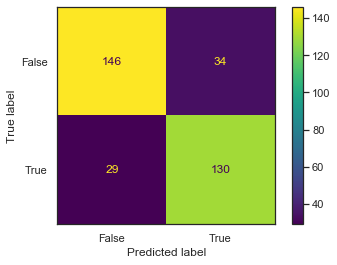

In [205]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#lambda0=0.0001, lambda1=0.0001,
boolean_model = BooleanRuleCG(silent=False,  CNF=False)
explainer = BRCGExplainer(boolean_model)
explainer.fit(X_train_fb, y_train)

y_pred = explainer.predict(X_test_fb)
print("Accuracy: {:2.2f}%".format(100.0*accuracy_score(y_test, y_pred)))
plot_confusion_matrix(y_test, y_pred, [False, True]);

In [162]:


e = explainer.explain()

# the labels are flipped between Conjunctive/Disjunctive normal forms
isCNF = 'No displacement crisis if ANY of the following rules are satisfied, otherwise predict displacement crisis:'
notCNF = 'Predict crisis if ANY of the following rules are satisfied, otherwise no:'
print(isCNF if e['isCNF'] else notCNF)
print()
for rule in e['rules']:
    print(f'  - {rule}')



Predict crisis if ANY of the following rules are satisfied, otherwise no:

  - VC.BTL.DETH > 368.00
  - FSI.SEC.APP <= 7.70 AND SP.PV.CIV.VIOL > 0.00
  - ACLED.FATALITIES > 1164.00 AND EMDAT.NAT.TOTAL.DEATHS <= 105.13 AND UC.EVT.STA <= 34.00
  - VC.BTL.DETH == NaN AND SP.POP.2529.FE.5Y <= 7.36 AND SP.GE.MAG.DEATH > 1.00
  - SP.POL.SCR.TWO > -8.00 AND EMDAT.NAT.TOTAL.AFFECTED > 883410.65 AND UC.EVT.STA > 0.00 AND EN.POP.DNST <= 78.13


- Battle-related deaths #persons (`VC.BTL.DETH`) > 368
OR
- Fragile States Index: Security Apparatus (0-10, where 10 is the most fragile) (`FSI.SEC.APP`) <=7.7 and Magnitude score of episode(s) of civil violence. Scale: 1 (lowest) to 10 (highest) (`)

Scaled annual number of deaths (`SP.GE.MAG.DEATH`) > 3.7
- IDP stock <85K and Average dietary energy supply adequacy (`ADESA`) > 121.0
- Battle-related deaths #persons (`VC.BTL.DETH`) > 1K AND Exclusion by Political Group index (`VDEM.EXL.POL.GRP`)>0.72
- Scaled collapse of democratic institutions (range 1-4; 9=missing)(`SP.SF.MAG.COLLAPSE`)>2.0 AND UNHCR total externally displaced persons (`UNHCR.EDP`) > 200K
- 


In [191]:
from typing import Dict, List

def translate(rules: List[str]) -> Dict:
    """
    Convert AIX360 rule set into pd.DataFrame query string.
    All queries are DNF, i.e. ORs of AND clauses
    """
    
    f_clauses = []
    for r in rules:
        conj = []
        clauses = [k.strip() for k in r.split('AND')]
        for c in clauses:

            field, op, value = c.split(' ')

            try:
                k = float(value)
                v = value
                
            except ValueError:
                # quotes for string values
                v = '"{}"'.format(value)

            qry = "`{}` {} {}".format(field, op, v)
            conj.append(qry)
        
        # A formatted rule set
        frmt_rule = " and ".join(conj)
        f_clauses.append(frmt_rule)
    
    all_rules = " or ".join(["({})".format(c) for c in f_clauses])
    return {'rule': all_rules, 'clauses': f_clauses}


def handle_err_columns(f_rules, df):
    
    invalid_column_names = [x for x in list(df.columns.values) if not x.isidentifier() ]
    # Make replacements in the query and keep track
    # NOTE: This method fails if the frame has columns called REPL_0 etc.
    replacements = dict()
    query = f_rules
    for cn in invalid_column_names:
        r = 'REPL_'+ str(invalid_column_names.index(cn))
        query = query.replace(cn, r)
        replacements[cn] = r

    inv_replacements = {replacements[k] : k for k in replacements.keys()}

    df = df.rename(columns=replacements) # Rename the columns
    df  = df.query(query) # Carry out query

    df = df.rename(columns=inv_replacements)

def support(rules, df, target='TARGET', classlabel=True):
    """ Conpute support for each atomic clause and overall rule set """

    clauses = []
    f_rules = translate(rules)
    
    #data, f_rules = handle_err_columns(f_rules, df)
    """
    for r in f_rules['clauses']:
        
        # The decision rule is of the form IF (rule) then classlabel else other_class
        pos_qry = "{} and `{}`=={}".format(r, target, classlabel)
        print(pos_qry)
        neg_qry = "~({}) and ~(`{}` == {})".format(r, target, classlabel)
        
        pos = df.query(pos_qry)
        neg = df.query(neg_qry)
        clauses.append({'rule': r, 'support': len(pos) + len(neg)}) 
    """
    pos_qry = "{} and `{}`=={}".format(f_rules['rule'], target, classlabel)
    neg_qry = "~({}) and ~(`{}` == {})".format(f_rules['rule'], target, classlabel)

    pos = df.query(pos_qry)
    neg = df.query(neg_qry)
    
    tot = "({}) or ({})".format(pos_qry, neg_qry)
    return {'rule': tot, 
                   'support': len(pos) + len(neg), 
                   'total': len(df),
                   'clauses': clauses}

In [192]:
sup = support(e['rules'], data)
tmp = df.query(sup['rule'])
idx = df.index.difference(tmp.index)
misclass = df.loc[idx]

SyntaxError: Python keyword not valid identifier in numexpr query (<unknown>, line 1)

In [173]:
translate(e['rules'])

{'rule': '(`VC.BTL.DETH` > 368.00) or (`FSI.SEC.APP` <= 7.70 and `SP.PV.CIV.VIOL` > 0.00) or (`ACLED.FATALITIES` > 1164.00 and `EMDAT.NAT.TOTAL.DEATHS` <= 105.13 and `UC.EVT.STA` <= 34.00) or (`VC.BTL.DETH` == NaN and `SP.POP.2529.FE.5Y` <= 7.36 and `SP.GE.MAG.DEATH` > 1.00) or (`SP.POL.SCR.TWO` > -8.00 and `EMDAT.NAT.TOTAL.AFFECTED` > 883410.65 and `UC.EVT.STA` > 0.00 and `EN.POP.DNST` <= 78.13)',
 'clauses': ['`VC.BTL.DETH` > 368.00',
  '`FSI.SEC.APP` <= 7.70 and `SP.PV.CIV.VIOL` > 0.00',
  '`ACLED.FATALITIES` > 1164.00 and `EMDAT.NAT.TOTAL.DEATHS` <= 105.13 and `UC.EVT.STA` <= 34.00',
  '`VC.BTL.DETH` == NaN and `SP.POP.2529.FE.5Y` <= 7.36 and `SP.GE.MAG.DEATH` > 1.00',
  '`SP.POL.SCR.TWO` > -8.00 and `EMDAT.NAT.TOTAL.AFFECTED` > 883410.65 and `UC.EVT.STA` > 0.00 and `EN.POP.DNST` <= 78.13']}

In [184]:
data.query("VC.BTL.DETH > 368.00")

UndefinedVariableError: name 'VC' is not defined

In [185]:
def handle_column_names(data, query):
    
    invalid_column_names = [x for x in list(data.columns.values) if not x.isidentifier() ]
    # Make replacements in the query and keep track
    # NOTE: This method fails if the frame has columns called REPL_0 etc.
    replacements = dict()
    for cn in invalid_column_names:
        r = 'REPL_'+ str(invalid_column_names.index(cn))
        query = query.replace(cn, r)
        replacements[cn] = r

    inv_replacements = {replacements[k] : k for k in replacements.keys()}

    df = df.rename(columns=replacements) # Rename the columns
    df  = df.query(query) # Carry out query

    df = df.rename(columns=inv_replacements)

In [186]:
invalid_column_names

['Country Code',
 'ACLED.COUNT',
 'ACLED.FATALITIES',
 'AG.PRD.FOOD.XD',
 'AG.PRD.LVSK.XD',
 'DRC.TOT.DISP',
 'EG.ELC.ACCS.ZS',
 'EMDAT.CPX.OCCURRENCE',
 'EMDAT.CPX.TOTAL.AFFECTED',
 'EMDAT.CPX.TOTAL.DAMAGE',
 'EMDAT.CPX.TOTAL.DEATHS',
 'EMDAT.NAT.OCCURRENCE',
 'EMDAT.NAT.TOTAL.AFFECTED',
 'EMDAT.NAT.TOTAL.DAMAGE',
 'EMDAT.NAT.TOTAL.DEATHS',
 'EMDAT.TEC.OCCURRENCE',
 'EMDAT.TEC.TOTAL.AFFECTED',
 'EMDAT.TEC.TOTAL.DAMAGE',
 'EMDAT.TEC.TOTAL.DEATHS',
 'EN.ATM.PM25.MC.M3',
 'EN.POP.DNST',
 'ER.GDP.FWTL.M3.KD',
 'ER.H2O.INTR.PC',
 'ETH.TO.DNK',
 'ETH.TO.GBR',
 'ETH.TO.ITA',
 'ETH.TO.SAU',
 'ETH.TO.SWE',
 'ETH.TO.ZAF',
 'FIW.CL',
 'FIW.PR',
 'FP.CPI.TOTL.ZG',
 'FSI.DEM.PRS',
 'FSI.ECON',
 'FSI.ECON.INQ',
 'FSI.EXT.INT',
 'FSI.FAC.ELI',
 'FSI.GRP.GRI',
 'FSI.HMN.FLI',
 'FSI.HMN.RIG',
 'FSI.PUB.SER',
 'FSI.REF.IDP',
 'FSI.SEC.APP',
 'FSI.STA.LEG',
 'HR.SCR.MEAN',
 'HR.SCR.SD',
 'IQ.CPA.PROP.XQ',
 'IT.NET.USER.ZS',
 'MMR.NSO.AARST',
 'MMR.NSO.AT',
 'MMR.NSO.ATST',
 'MMR.NSO.BRR',
 'MMR.NSO.FPPR